In [1]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import warnings
import pandas as pd
import numpy as np
import time
import esm
import biotite.structure.io as bsio

from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG
from proteinttt.utils.structure import calculate_tm_score, lddt_score

import seaborn as sns
import matplotlib.pyplot as plt

import torch
print(f"CUDA available: {torch.cuda.is_available()}")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd")
DATASET_PATH = Path("/scratch/project/open-32-14/antonb/bfvd/2023_02_v2-entry_nmsa_plddt_version.tsv")
OUTPUT_PDB = base_path / Path('predicted_structures')
SUMMARY_PATH = base_path / Path('subset_1.tsv')
SAVE_PATH = base_path / Path('prior_out.tsv')
CLEAN_DF_PATH = base_path / Path('subset_1.tsv')
RESULTS_PATH = base_path / Path('results.tsv')

CORRECT_PREDICTED_PDB = Path("/scratch/project/open-32-14/antonb/bfvd/bfvd")
# os.makedirs(CDR_PATH, exist_ok=True)

# os.makedirs(base_path, exist_ok=True)

/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: False


In [5]:
len(os.listdir(OUTPUT_PDB))

420908

In [1]:
# from proteinttt.utils.parsers import fetch_and_parse_sequences
# df_new = fetch_and_parse_sequences(df, CORRECT_PREDICTED_PDB, 'id')
# df.to_csv(path_or_buf=base_path / "prior.tsv", sep="\t", index=False)

## Dataset

In [5]:
df_clean = pd.read_csv(CLEAN_DF_PATH, sep="\t")
results = pd.read_csv(RESULTS_PATH, sep="\t")
df_done = pd.concat([df_clean, results], axis=0)
df_done

,id,sequence,lenghth,pLDDT_after,pLDDT_before,tm_score_before,tm_score_after,lddt_before,lddt_after,plddt_AlphaFold,time,chain,chain_type,resolution
0,A0A2D1GNP4,MSEQIVVTDDENFSASWKVVSDAINDTKTVLDRSLAQLDGIAPPLPELQGVVVYNEGWLPTKPEPTDYTENPDGSVSFVDQQVIRTTPVPATDTAL...,279,NaN,NaN,NaN,NaN,NaN,NaN,27.544796,NaN,NaN,NaN,NaN
1,A0A0K1RMB7,VPGGFSTCNRHWNLNGSTFGWSSPRFAAIDHDRGNASFPGGSSSNVLELWYASAGSAADNPISQIAPDGFPDMSFVPFSGTTIPTAGWVGFGGIWN...,312,NaN,NaN,NaN,NaN,NaN,NaN,28.295470,NaN,NaN,NaN,NaN
2,A0A2I7RYJ4,MKGNIMNTFELSVINQEAHVALRLITTDGGAPQGTIADIREVTGVDVETCLAKVWNWFVNRERLALVSRDGTAFPYRGGKTFIKAALAFIEHNTPK...,207,NaN,NaN,NaN,NaN,NaN,NaN,29.216449,NaN,NaN,NaN,NaN
3,A0A075VR24,MYIYSMISLVLTITLSPSIHIISKRPAERLFFMYCWEHSSPFVNHLCTWTLSTVGYQNIHHPFVHFDECHLARRQPIPRFRVQINVGLRSQPLKQF...,234,NaN,NaN,NaN,NaN,NaN,NaN,30.046297,NaN,NaN,NaN,NaN
4,A0A1W6QDY9,MPYFGLNLLGSTVLDEFKNRFNSIKLVRLSLTMKAACQRPAWDDTYHHSGSVWSLPRLQFCMSHDAAEWQKHSTAIAGQECRKPVDTFLATKYNWR...,208,NaN,NaN,NaN,NaN,NaN,NaN,30.399183,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248513,A0A4D5ZDH9,MRATHAKLEVTGDRSALITADILARFIGSEITYLADLVDDTQPLRVVNLRFRGDLADLHGEKIMLPFADAVRGGKALGLLIKRINCATAQVGYAAH...,127,53.226218,30.648798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248514,K9L456,MGNQQERQLTSIPDFKGYYFCEDGHIYSDRRGKIKRLKEHKHGGKTKKIYYRVKLWDKCYLVHRLIGAFIAGRKLLPDEHVNHLDGDTENNKPLNL...,127,NaN,72.204681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248515,Q8JMD8,MLEMATSNRLLHRGPTSKVLALSVFKKINQRVFDGRLKNVSIIWTTYINIRSSGRTVYNHRTKQCYILLSVRLLNNNQYGCLFGKIIHEMCHAAVY...,127,71.602810,69.365893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248516,A7K9U4,MIPALDVEARGVQEDLATIGKGELAIAQVLTLLGLLCLVILGGRTQRLEDGLDKVLVGEGLESALPNREVGLGTDKAVHDARHGLGVLGPGRNGLE...,127,30.883059,30.788114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
columns = ['id', 'num', 'pLDDT_Alpha', 'model']
df = pd.read_csv(DATASET_PATH, names=columns, sep='\t', header=None)
df

,id,num,pLDDT_Alpha,model
0,A0A2P1GMZ4_2,153,43.168,BASE
1,A0A2P1GMZ4_3,161,60.193,BASE
2,A0A2P1GMZ4_4,384,77.229,BASE
3,A0A2P1GMZ4_5,412,77.320,BASE
4,E3SJZ4_1,8329,85.924,BASE
...,...,...,...,...
351237,A0A8S5TYY3,90,85.360,BASE+LOGAN+12CY
351238,A0A059PYE1,1204,77.820,BASE+LOGAN+12CY
351239,A0A8S5T1N2,34,64.898,BASE+LOGAN+12CY
351240,A0A1L3KGH8,43,48.175,BASE+LOGAN+12CY


In [14]:
results.query("plddt_AlphaFold > 70").shape[0] / results.shape[0]

0.6431807756379819

In [ ]:
# df.to_csv(path_or_buf=base_path / "df_new_seq.tsv", sep="\t", index=False)

In [38]:
df_new = df[~df['id'].isin(df_done['id'])]

In [ ]:
# df_new.to_csv(base_path / Path("df_new.tsv"), sep="\t", index=False)

In [7]:
new_df = pd.DataFrame(columns=df.columns)
new_df_num = pd.DataFrame(columns=df.columns)
for i, row in df.iterrows():
    try:
        num = row.get('id').split('_')[1]
        new_df_num = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)
    except Exception as e:
        new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)

/tmp/ipykernel_2986047/2027296037.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df_num = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)
/tmp/ipykernel_2986047/2027296037.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


In [8]:
new_df

,id,length,pLDDT_A,model
0,A0A7S5UZU3,1675,56.081,BASE
1,A0A7S5T4G4,150,58.324,BASE
2,A0A8J9W5Z0,2330,73.601,BASE
3,A0A6J5LA39,11489,53.762,BASE
4,J9PUL9,1680,56.782,BASE
...,...,...,...,...
42714,A0A8S5TYY3,90,85.360,BASE+LOGAN+12CY
42715,A0A059PYE1,1204,77.820,BASE+LOGAN+12CY
42716,A0A8S5T1N2,34,64.898,BASE+LOGAN+12CY
42717,A0A1L3KGH8,43,48.175,BASE+LOGAN+12CY


In [ ]:
from proteinttt.utils.parsers import fetch_and_parse_sequences
new_df_seq = fetch_and_parse_sequences(new_df, CORRECT_PREDICTED_PDB, 'id')
new_df_seq.to_csv(path_or_buf=base_path / "df_new_seq.tsv", sep="\t", index=False)
new_df_seq

In [1]:
new_df_seq

NameError: name 'new_df_seq' is not defined

In [7]:
# rows = []
# with open(DATASET_PATH) as fh:
#     for title, seq in SimpleFastaParser(fh):
#         rows.append({"id": title, "seq": seq, "len": len(seq)})
# df = pd.DataFrame(rows)
# df.head(5)

## Model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

base_model = esm.pretrained.esmfold_v1().eval().to(device)

ttt_cfg = DEFAULT_ESMFOLD_TTT_CFG
ttt_cfg.steps = 20
ttt_cfg.seed = 0
model = ESMFoldTTT.ttt_from_pretrained(base_model,
                                       ttt_cfg=ttt_cfg,
                                       esmfold_config=base_model.cfg).to(device)

Using cuda


In [9]:
def predict_structure(model, sequence, pdb_id, tag, out_dir=OUTPUT_PDB):
    with torch.no_grad():
        pdb_str = model.infer_pdb(sequence)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    out_path = out_dir / f"{pdb_id}{tag}.pdb"
    out_path.write_text(pdb_str)

    struct = bsio.load_structure(out_path, extra_fields=["b_factor"])
    pLDDT = float(np.asarray(struct.b_factor, dtype=float).mean())

    return pLDDT


def fold_chain(sequence, pdb_id, *, model, tag, out_dir=OUTPUT_PDB):
    model.ttt(sequence)
    pLDDT_after = predict_structure(model, sequence, pdb_id, tag='_ttt', out_dir=out_dir)
    model.ttt_reset()
    return pLDDT_after

def calculate_metrics(true_path, pred_path):
    true_struct = bsio.load_structure(true_path, extra_fields=["b_factor"])
    plddt_alpha = float(np.asarray(true_struct.b_factor, dtype=float).mean())
    
    tm_score = calculate_tm_score(pred_path, true_path)
    lddt = lddt_score(true_path, pred_path)

    return tm_score, lddt, plddt_alpha

In [10]:
num_of_low = 0
col = 'sequence'
len_col = 'lenghth'

In [11]:
# for i, row in df.iterrows():
    # if pd.isna(row['pLDDT_after']):
    #     continue
    # id_seq = str(row.get("id"))
    
    # tm_score_before, lddt_before, pldd_alphafold = calculate_metrics(
    #     true_path=CORRECT_PREDICTED_PDB / f"{id_seq}.pdb",
    #     pred_path=OUTPUT_PDB / f"{id_seq}.pdb"
    # )
    # tm_score_after, lddt_after, _ = calculate_metrics(
    #     true_path=CORRECT_PREDICTED_PDB / f"{id_seq}.pdb",
    #     pred_path=OUTPUT_PDB / f"{id_seq}_ttt.pdb"
    # )
    
    # true_struct = bsio.load_structure(CORRECT_PREDICTED_PDB / f"{id_seq}.pdb", extra_fields=["b_factor"])
    # plddt_alpha = float(np.asarray(true_struct.b_factor, dtype=float).mean())
    
    # df.at[i, 'tm_score_before'] = tm_score_before
    # df.at[i, 'lddt_before'] = lddt_before
    
    # df.at[i, 'lddt_after'] = lddt_after
    # df.at[i, 'tm_score_after'] = tm_score_after
    
    # df.at[i, 'plddt_AlphaFold'] = plddt_alpha

    # print(f"tm_score before: {tm_score_before:.3f}, after: {tm_score_after:.3f}; ")

In [12]:
# df['tm_score_difference'] = df['tm_score_after'] - df['tm_score_before']

In [13]:
# --- Main Processing Loop ---
start_time = time.time()
col = 'sequence'
len_col = 'lenghth'
processed_count = 0

for i, row in df.iterrows():
    if row[len_col] > 400 or row[len_col] < 30 or pd.notna(row['pLDDT_after']):
        continue

    if pd.isna(row[col]):
        continue
    
    start_seq_time = time.time()
    processed_count += 1
    seq_id = str(row.get("id"))
    seq = str(row[col]).strip().upper()

    pLDDT_before, pLDDT_after, tm_score_before, lddt_before, pldd_alphafold, tm_score_after, lddt_after = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

# HANDLE ALREADY PROCESSED ------------------------------
    if (OUTPUT_PDB / f"{seq_id}.pdb").exists():
        try:
            tm_score_before, lddt_before, pldd_alphafold = calculate_metrics(
                true_path=CORRECT_PREDICTED_PDB / f"{seq_id}.pdb",
                pred_path=OUTPUT_PDB / f"{seq_id}.pdb"
            )
        except Exception as e:
            warnings.warn(f"Error calculating metrics: {seq_id}: {e}")
        pLDDT_before = float(bsio.load_structure(OUTPUT_PDB / f"{seq_id}.pdb", extra_fields=["b_factor"]).b_factor.mean())
        
        df.at[i, 'tm_score_before'] = tm_score_before
        df.at[i, 'lddt_before'] = lddt_before
        df.at[i, 'plddt_AlphaFold'] = pldd_alphafold
        df.at[i, 'pLDDT_before'] = pLDDT_before
                
        if (OUTPUT_PDB / f"{seq_id}_ttt.pdb").exists():
            try:
                tm_score_after, lddt_after, _ = calculate_metrics(
                    true_path=CORRECT_PREDICTED_PDB / f"{seq_id}.pdb",
                    pred_path=OUTPUT_PDB / f"{seq_id}_ttt.pdb"
                )
            except Exception as e:
                warnings.warn(f"{seq_id}: {e}")
            pLDDT_after = float(bsio.load_structure(OUTPUT_PDB / f"{seq_id}_ttt.pdb", extra_fields=["b_factor"]).b_factor.mean())
            
            df.at[i, 'pLDDT_after'] = pLDDT_after
            df.at[i, 'lddt_after'] = lddt_after
            df.at[i, 'tm_score_after'] = tm_score_after
        elif pLDDT_before < 70:
            try:
                pLDDT_after = fold_chain(seq, seq_id, model=model, tag="")
            except Exception as e:
                warnings.warn(f"Error folding chain for {seq_id}: {e}")
                
            df.at[i, 'pLDDT_after'] = pLDDT_after
            
        print(f"Existed sequence {i} (ID: {seq_id}). pLDDT before: {pLDDT_before:.2f}, after: {pLDDT_after:.2f}")
        continue

# BEFORE ------------------------------

    try:
        pLDDT_before = predict_structure(model, seq, seq_id, tag="")
    except Exception as e:
        continue

    try:
        tm_score_before, lddt_before, pldd_alphafold = calculate_metrics(
        true_path=CORRECT_PREDICTED_PDB / f"{seq_id}.pdb",
        pred_path=OUTPUT_PDB / f"{seq_id}.pdb"
        )   
    except Exception as e:
        warnings.warn(f"Error calculating metrics: {seq_id}: {e}")

# AFTER ------------------------------

    if pLDDT_before < 70:
        try:
            pLDDT_after = fold_chain(seq, seq_id, model=model, tag="")
        except Exception as e:
            warnings.warn(f"Error folding chain for {seq_id}: {e}")
        
        try:
            tm_score_after, lddt_after, _ = calculate_metrics(
                true_path=CORRECT_PREDICTED_PDB / f"{seq_id}.pdb",
                pred_path=OUTPUT_PDB / f"{seq_id}_ttt.pdb"
            )
        except Exception as e:
            warnings.warn(f"{seq_id}: {e}")

    df.at[i, 'pLDDT_after'] = pLDDT_after
    df.at[i, 'pLDDT_before'] = pLDDT_before
    
    df.at[i, 'time'] = time.time() - start_seq_time
    df.at[i, 'tm_score_before'] = tm_score_before
    df.at[i, 'lddt_before'] = lddt_before

    df.at[i, 'lddt_after'] = lddt_after
    df.at[i, 'tm_score_after'] = tm_score_after

    df.at[i, 'plddt_AlphaFold'] = pldd_alphafold

    print(f"Processed sequence {i} (ID: {seq_id}). pLDDT before: {pLDDT_before:.2f}, after: {pLDDT_after:.2f}")

    if processed_count > 0 and processed_count % 50 == 0:
        df.to_csv(path_or_buf=SAVE_PATH, sep="\t", index=False)
        print(f"Saved progress. Total time elapsed: {time.time() - start_time:.2f} seconds for {processed_count} sequences.")

# --- Final Save ---
end_time = time.time()
print(f"Processing complete. Total time elapsed: {end_time - start_time:.2f} seconds for {processed_count} sequences.")
df.to_csv(SAVE_PATH, sep="\t", index=False)
print("Final results saved.")

Existed sequence 0 (ID: A0A068EP60). pLDDT before: 44.71, after: 57.06
Existed sequence 1 (ID: A0A097I2D0). pLDDT before: 81.87, after: nan
Existed sequence 3 (ID: A0A0A1IVS8). pLDDT before: 84.48, after: nan
Existed sequence 4 (ID: A0A0X1KHD2). pLDDT before: 87.09, after: nan
Existed sequence 5 (ID: A0A140UHM9). pLDDT before: 83.37, after: nan
Existed sequence 7 (ID: A0A1B3SN05). pLDDT before: 79.99, after: nan
Existed sequence 8 (ID: A0A1L3KI27). pLDDT before: 34.12, after: 42.50
Existed sequence 9 (ID: A0A1L3KI37). pLDDT before: 35.66, after: 49.14
Existed sequence 10 (ID: A0A1L3KI97). pLDDT before: 50.12, after: 67.42
Existed sequence 11 (ID: A0A1L3KIU2). pLDDT before: 37.98, after: 46.57
Existed sequence 12 (ID: A0A1L4BKA3). pLDDT before: 62.27, after: 67.56
Existed sequence 13 (ID: A0A1P8CWQ8). pLDDT before: 79.22, after: nan
Existed sequence 15 (ID: A0A4Y5TPY8). pLDDT before: 43.57, after: 57.42
Existed sequence 16 (ID: A0A4Y5TR23). pLDDT before: 75.70, after: nan
Existed sequen

Existed sequence 124 (ID: UPI0001BE64DC). pLDDT before: 40.62, after: 54.05
Existed sequence 125 (ID: UPI0001BE667B). pLDDT before: 58.60, after: 63.36
Existed sequence 126 (ID: UPI0001C39768). pLDDT before: 87.33, after: nan
Existed sequence 128 (ID: UPI0001E3063F). pLDDT before: 73.39, after: nan
Existed sequence 129 (ID: UPI0001E3064D). pLDDT before: 80.02, after: nan
Existed sequence 130 (ID: UPI0001E6904E). pLDDT before: 75.93, after: nan
Existed sequence 131 (ID: UPI0001F5505B). pLDDT before: 62.39, after: 70.31
Existed sequence 134 (ID: UPI000211B3AC). pLDDT before: 72.42, after: nan
Existed sequence 135 (ID: UPI00021472DB). pLDDT before: 81.26, after: nan
Existed sequence 136 (ID: UPI0002177BA6). pLDDT before: 37.25, after: 52.67
Existed sequence 137 (ID: UPI00022A9A93). pLDDT before: 30.16, after: 38.90
Existed sequence 138 (ID: UPI00022B80E1). pLDDT before: 77.38, after: nan
Existed sequence 139 (ID: UPI0002380B23). pLDDT before: 59.06, after: 68.20
Existed sequence 140 (ID: 

Existed sequence 251 (ID: UPI00142F3CB1). pLDDT before: 34.25, after: 42.79
Existed sequence 252 (ID: UPI00144A4C99). pLDDT before: 40.85, after: 43.07
Existed sequence 253 (ID: UPI00148AE299). pLDDT before: 62.30, after: 62.30
Existed sequence 254 (ID: UPI001551637C). pLDDT before: 77.60, after: nan
Existed sequence 255 (ID: UPI0015E26F99). pLDDT before: 72.67, after: nan
Existed sequence 256 (ID: UPI001652B718). pLDDT before: 36.60, after: 40.19
Existed sequence 257 (ID: UPI001652B71D). pLDDT before: 31.30, after: 37.81
Existed sequence 258 (ID: UPI001652B792). pLDDT before: 29.84, after: 44.49
Existed sequence 259 (ID: UPI0018A7E306). pLDDT before: 40.74, after: 58.68
Existed sequence 260 (ID: UPI0018C8D4D4). pLDDT before: 31.85, after: 62.34
Existed sequence 261 (ID: UPI001A9A2C2E). pLDDT before: 70.73, after: nan
Existed sequence 262 (ID: UPI001B7F7958). pLDDT before: 69.80, after: 69.80
Existed sequence 263 (ID: UPI001B7F797F). pLDDT before: 70.11, after: nan
Existed sequence 264

In [20]:
df.to_csv(SAVE_PATH, sep="\t", index=False)

Entries with pLDDT before and after: 144


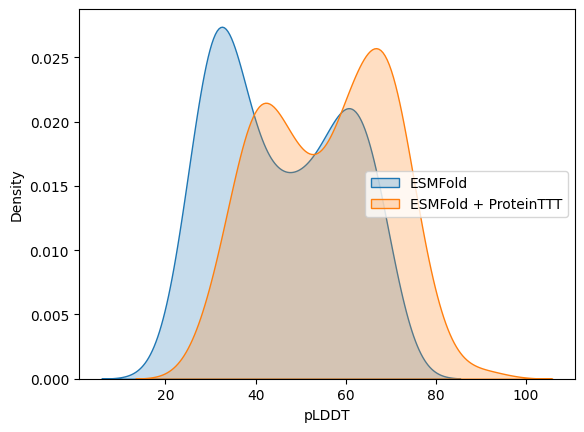

In [21]:
sub_df = df.query("pLDDT_before.notna() and pLDDT_after.notna()")
print(f"Entries with pLDDT before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
# sns.kdeplot(sub_df['plddt_AlphaFold'], label='AlphaFold', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

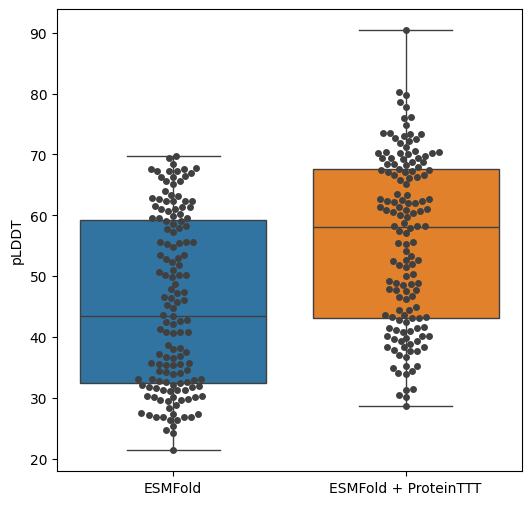

In [16]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=sub_df[['pLDDT_before', 'pLDDT_after']])
sns.swarmplot(data=sub_df[['pLDDT_before', 'pLDDT_after']], color=".25")
plt.ylabel('pLDDT')
plt.xticks([0, 1], ['ESMFold', 'ESMFold + ProteinTTT'])
plt.show()  

0.7663230335895183 nan


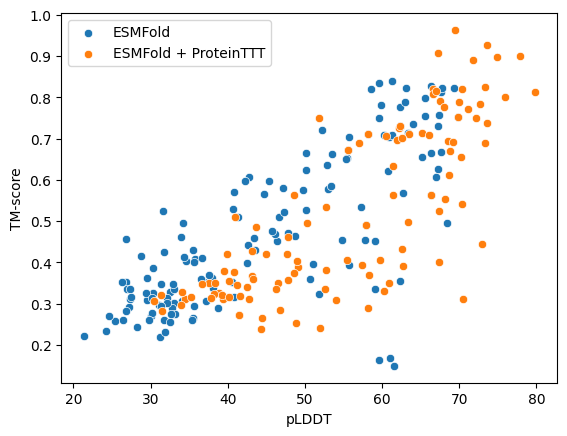

In [17]:
print(np.corrcoef(sub_df['pLDDT_before'], sub_df['tm_score_before'])[0, 1], np.corrcoef(sub_df['pLDDT_after'], y=sub_df['tm_score_after'])[0, 1])
sns.scatterplot(data=sub_df, x='pLDDT_before', y='tm_score_before', label='ESMFold')
sns.scatterplot(data=sub_df, x='pLDDT_after', y='tm_score_after', label='ESMFold + ProteinTTT')
plt.xlabel('pLDDT')
plt.ylabel('TM-score')
plt.legend()
plt.show()

0.8441639581531195 nan


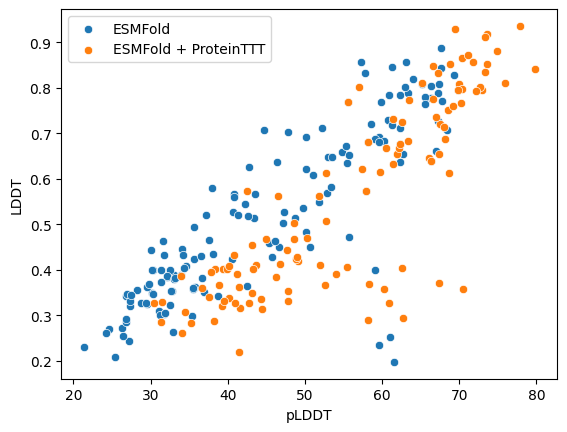

In [18]:
print(np.corrcoef(sub_df['pLDDT_before'], sub_df['lddt_before'])[0, 1], np.corrcoef(sub_df['pLDDT_after'], sub_df['lddt_after'])[0, 1])
sns.scatterplot(sub_df, x='pLDDT_before', y='lddt_before', label='ESMFold')
sns.scatterplot(sub_df, x='pLDDT_after', y='lddt_after', label='ESMFold + ProteinTTT')
plt.xlabel('pLDDT')
plt.ylabel('LDDT')
plt.legend()

In [19]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=sub_df[['tm_score_difference']])
sns.swarmplot(data=sub_df[['tm_score_difference']], color=".25")
plt.ylabel('tm_score_difference')
# plt.xticks([0, 1], ['tm_score_difference'])
plt.show()

KeyError: "None of [Index(['tm_score_difference'], dtype='object')] are in the [columns]"

<Figure size 600x600 with 0 Axes>

In [ ]:
sub_df.pLDDT_before.describe(), sub_df.pLDDT_after.describe()

In [ ]:
sub_df